In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score


In [3]:
# Load datasets
customers = pd.read_csv("Customers.csv")
products = pd.read_csv("Products.csv")
transactions = pd.read_csv("Transactions.csv")

# Preview datasets
print("Customers Dataset:")
print(customers.head())
print("\nProducts Dataset:")
print(products.head())
print("\nTransactions Dataset:")
print(transactions.head())


Customers Dataset:
  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15

Products Dataset:
  ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books  169.30
1      P002    ActiveWear Smartwatch  Electronics  346.30
2      P003  ComfortLiving Biography        Books   44.12
3      P004            BookWorld Rug   Home Decor   95.69
4      P005          TechPro T-Shirt     Clothing  429.31

Transactions Dataset:
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166   

In [4]:
# Merge datasets for analysis
merged_data = transactions.merge(customers, on="CustomerID").merge(products, on="ProductID")
print("Merged Dataset:")
print(merged_data.head())


Merged Dataset:
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue  Price_x     CustomerName         Region  SignupDate  \
0      300.68   300.68   Andrea Jenkins         Europe  2022-12-03   
1      300.68   300.68  Brittany Harvey           Asia  2024-09-04   
2      300.68   300.68  Kathryn Stevens         Europe  2024-04-04   
3      601.36   300.68  Travis Campbell  South America  2024-04-11   
4      902.04   300.68    Timothy Perez         Europe  2022-03-15   

                       ProductName     Category  Price_y  
0  ComfortLiving Bluetooth Speaker  Electronics   300.68  
1  ComfortLiving B

In [6]:
# Correct code
top_products = merged_data.groupby("ProductName")["TotalValue"].sum().sort_values(ascending=False)
print("Top 5 Products by Revenue:")
print(top_products.head())



Top 5 Products by Revenue:
ProductName
ActiveWear Smartwatch    39096.97
SoundWave Headphones     25211.64
SoundWave Novel          24507.90
ActiveWear Jacket        22712.56
ActiveWear Rug           22314.43
Name: TotalValue, dtype: float64


In [7]:
region_revenue = merged_data.groupby("Region")["TotalValue"].sum()
print("Revenue by Region:")
print(region_revenue)


Revenue by Region:
Region
Asia             152074.97
Europe           166254.63
North America    152313.40
South America    219352.56
Name: TotalValue, dtype: float64


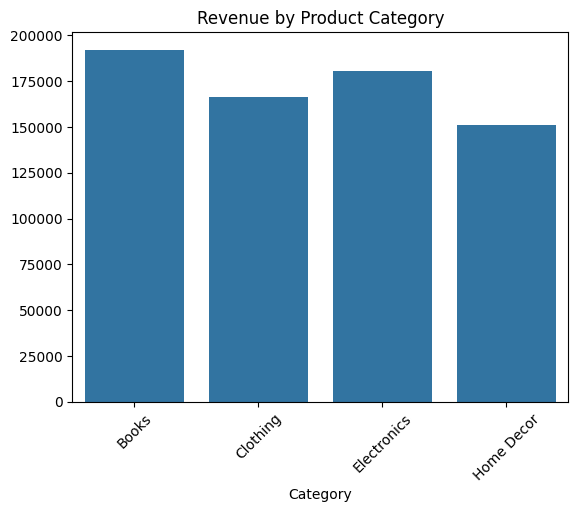

In [8]:
category_revenue = merged_data.groupby("Category")["TotalValue"].sum()
sns.barplot(x=category_revenue.index, y=category_revenue.values)
plt.title("Revenue by Product Category")
plt.xticks(rotation=45)
plt.show()


In [9]:
customer_features = merged_data.groupby("CustomerID").agg({
    "TotalValue": "sum",
    "TransactionID": "count"
}).rename(columns={"TotalValue": "TotalSpent", "TransactionID": "TransactionCount"}).reset_index()
print(customer_features.head())


  CustomerID  TotalSpent  TransactionCount
0      C0001     3354.52                 5
1      C0002     1862.74                 4
2      C0003     2725.38                 4
3      C0004     5354.88                 8
4      C0005     2034.24                 3


In [10]:
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(customer_features[["TotalSpent", "TransactionCount"]])


In [11]:
similarity_matrix = cosine_similarity(scaled_features)


In [12]:
lookalikes = {}
for idx, customer_id in enumerate(customer_features["CustomerID"][:20]):
    sim_scores = list(enumerate(similarity_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:4]
    lookalikes[customer_id] = [(customer_features["CustomerID"][i], score) for i, score in sim_scores]

print("Lookalikes for First 20 Customers:")
for key, value in lookalikes.items():
    print(f"Customer {key}: {value}")


Lookalikes for First 20 Customers:
Customer C0001: [('C0173', np.float64(0.9999999987151875)), ('C0145', np.float64(0.9999949919723209)), ('C0137', np.float64(0.9999946982680763))]
Customer C0002: [('C0103', np.float64(0.9999993502213471)), ('C0024', np.float64(0.9999981371395569)), ('C0034', np.float64(0.9999942994376945))]
Customer C0003: [('C0155', np.float64(0.9999996159457006)), ('C0132', np.float64(0.9999981597569649)), ('C0107', np.float64(0.9999970204752502))]
Customer C0004: [('C0164', np.float64(0.9999993005704118)), ('C0156', np.float64(0.9999992214244011)), ('C0021', np.float64(0.9999831686571975))]
Customer C0005: [('C0193', np.float64(0.9999999885232681)), ('C0092', np.float64(0.9999995186259848)), ('C0100', np.float64(0.9999911360325124))]
Customer C0006: [('C0138', np.float64(0.9999999966050629)), ('C0079', np.float64(0.9999961241266716)), ('C0148', np.float64(0.9999093043993703))]
Customer C0007: [('C0082', np.float64(0.9999999927393766)), ('C0085', np.float64(0.999993

In [13]:
kmeans = KMeans(n_clusters=3, random_state=42)
customer_features["Cluster"] = kmeans.fit_predict(scaled_features)


In [14]:
db_index = davies_bouldin_score(scaled_features, customer_features["Cluster"])
print("Davies-Bouldin Index:", db_index)


Davies-Bouldin Index: 0.7520285743713337


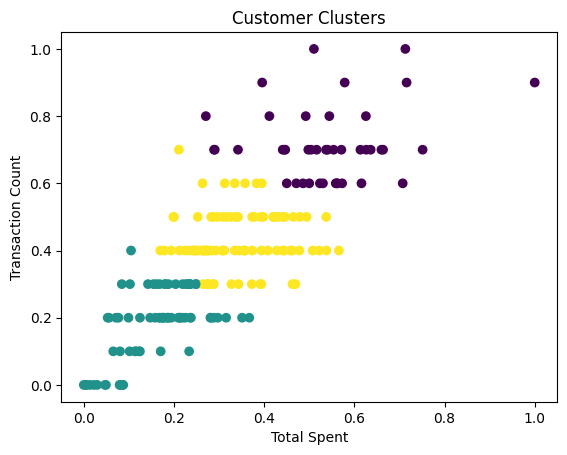

In [15]:
plt.scatter(scaled_features[:, 0], scaled_features[:, 1], c=customer_features["Cluster"], cmap="viridis")
plt.xlabel("Total Spent")
plt.ylabel("Transaction Count")
plt.title("Customer Clusters")
plt.show()
